0:	learn: 0.6783071	total: 1.27ms	remaining: 1.27s
1:	learn: 0.6662808	total: 2.75ms	remaining: 1.37s
2:	learn: 0.6551691	total: 4.06ms	remaining: 1.35s
3:	learn: 0.6440528	total: 5.33ms	remaining: 1.33s
4:	learn: 0.6337655	total: 6.28ms	remaining: 1.25s
5:	learn: 0.6242130	total: 6.98ms	remaining: 1.16s
6:	learn: 0.6148437	total: 7.82ms	remaining: 1.11s
7:	learn: 0.6062917	total: 8.56ms	remaining: 1.06s
8:	learn: 0.5970586	total: 9.19ms	remaining: 1.01s
9:	learn: 0.5888148	total: 9.98ms	remaining: 988ms
10:	learn: 0.5799593	total: 10.8ms	remaining: 968ms
11:	learn: 0.5718968	total: 11.8ms	remaining: 972ms
12:	learn: 0.5634519	total: 12.4ms	remaining: 941ms
13:	learn: 0.5560831	total: 13.1ms	remaining: 922ms
14:	learn: 0.5490142	total: 13.7ms	remaining: 902ms
15:	learn: 0.5419921	total: 14.4ms	remaining: 885ms
16:	learn: 0.5351298	total: 15.2ms	remaining: 881ms
17:	learn: 0.5286701	total: 16.1ms	remaining: 881ms
18:	learn: 0.5224646	total: 17.2ms	remaining: 891ms
19:	learn: 0.5169639	t

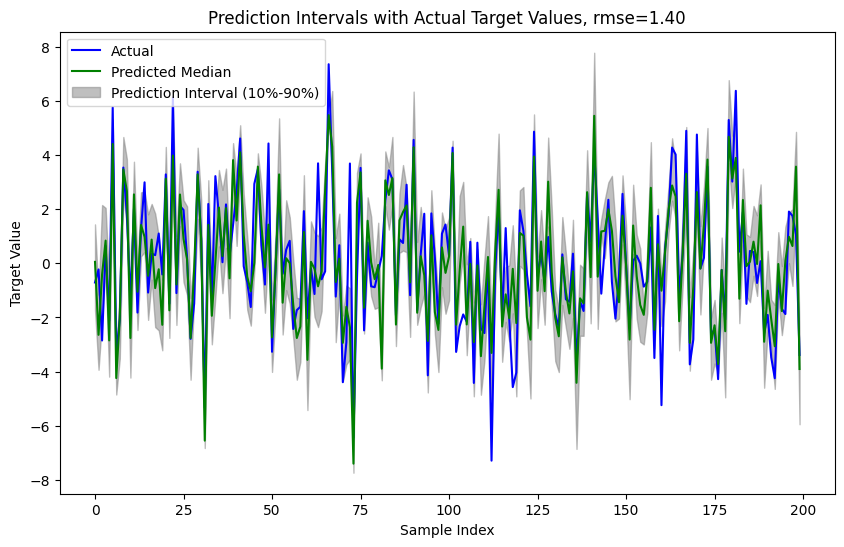

In [24]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
X = np.random.randn(1000, 2)
y = X[:, 0] + 2 * X[:, 1] + np.random.standard_t(df=3, size=1000)

# Split the data into training and testing sets
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]


# Define the quantile levels
quantile_levels = [0.1, 0.5, 0.9]
quantile_str = str(quantile_levels).replace('[','').replace(']','')

# Define the model parameters
params = {
    'iterations': 1000,
    'depth': 6,
}


# Initialize the CatBoostRegressor with MultiQuantile loss function
model = CatBoostRegressor(
    loss_function=f'MultiQuantile:alpha={quantile_str}',
    **params,
)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Compute the coverage
lower_bound = predictions[:, 0]
median = predictions[:, 1]
upper_bound = predictions[:, 2]
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
print(f'Coverage: {coverage * 100:.2f}%')

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions[:, 1]))

# Plot the prediction intervals with the actual target values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions[:, 1], label='Predicted Median', color='green')
plt.fill_between(np.arange(len(y_test)), lower_bound, upper_bound, color='gray', alpha=0.5, label='Prediction Interval (10%-90%)')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f'Prediction Intervals with Actual Target Values, rmse={rmse:.2f}')
plt.show()

In [26]:
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn.linear_model import LinearRegression

# Install MAPIE library if not already installed
X_calib, y_calib = X_test, y_test

#cqr = MapieQuantileRegressor(estimator=model, cv='prefit')
list_estimators_cqr = []
for alpha_ in quantile_levels:
    estimator_ = CatBoostRegressor(
        loss_function=f'Quantile:alpha={alpha_}',
        **params,
    )
    estimator_.fit(X_train, y_train)
    list_estimators_cqr.append(estimator_)

mapie_reg = MapieQuantileRegressor(list_estimators_cqr, cv='prefit', alpha=0.9)
mapie_reg.fit(X_calib, y_calib)
y_pred_cqr, y_pis_cqr = mapie_reg.predict(X_test)

lower_bound_cqr = y_pis_cqr[:, 0]
median_cqr = y_pred_cqr
upper_bound_cqr = y_pis_cqr[:, 1]

0:	learn: 0.4809399	total: 569us	remaining: 569ms
1:	learn: 0.4738158	total: 1.27ms	remaining: 635ms
2:	learn: 0.4669801	total: 1.91ms	remaining: 634ms
3:	learn: 0.4594928	total: 2.34ms	remaining: 583ms
4:	learn: 0.4532589	total: 2.72ms	remaining: 541ms
5:	learn: 0.4469092	total: 3.14ms	remaining: 521ms
6:	learn: 0.4405166	total: 3.55ms	remaining: 504ms
7:	learn: 0.4355910	total: 3.96ms	remaining: 491ms
8:	learn: 0.4304204	total: 4.39ms	remaining: 483ms
9:	learn: 0.4257203	total: 4.76ms	remaining: 471ms
10:	learn: 0.4210861	total: 5.42ms	remaining: 488ms
11:	learn: 0.4158073	total: 6.07ms	remaining: 500ms
12:	learn: 0.4108745	total: 6.54ms	remaining: 496ms
13:	learn: 0.4056907	total: 7.04ms	remaining: 496ms
14:	learn: 0.4013596	total: 7.45ms	remaining: 489ms
15:	learn: 0.3971681	total: 7.84ms	remaining: 482ms
16:	learn: 0.3923286	total: 8.18ms	remaining: 473ms
17:	learn: 0.3887428	total: 8.57ms	remaining: 467ms
18:	learn: 0.3857078	total: 8.91ms	remaining: 460ms
19:	learn: 0.3824011	to

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class MapieQuantileRegressor is deprecated; WARNING: Deprecated path to import MapieQuantileRegressor. Please prefer the new path: [from mapie.regression import MapieQuantileRegressor].
  warnings.warn(msg, category=FutureWarning)
/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/mapie/regression/quantile_regression.py:201: UserWarning: WARNING: The alpha that is set needs to be the same as the alpha of your prefitted model in the following order [alpha/2, 1 - alpha/2, 0.5]
  warnings.warn(
/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


In [28]:
 = mapie_cqr.predict(

AttributeError: 'tuple' object has no attribute 'shape'

In [15]:
y_test

array([-7.09429620e-01, -2.27987265e-01, -2.85010835e+00,  6.42723564e-01,
       -2.12587176e+00,  5.75295798e+00, -3.34026545e+00, -2.05705863e+00,
        3.53379029e+00,  1.80049437e+00, -1.38408496e+00,  2.01186833e+00,
       -1.81893353e+00,  1.26482179e+00,  2.98931642e+00, -1.08039465e+00,
        3.56543562e-01,  2.99953012e-01,  1.09839184e+00, -4.10924389e-01,
        3.28175818e+00, -1.48921295e+00,  6.12255761e+00, -1.10057376e+00,
        2.11453507e+00,  1.96957372e+00,  2.21812305e-01, -2.79036270e+00,
       -1.49026601e+00,  3.37927013e+00,  8.99578833e-01, -5.32531281e+00,
        2.18982165e+00, -1.33469803e+00,  3.21781765e+00,  1.75683225e+00,
        3.90081497e-02,  2.17416552e+00,  2.54844050e-01,  1.42338829e+00,
        2.65315202e+00,  4.60812339e+00, -1.08240483e-01, -6.95790723e-01,
       -1.61385100e+00,  2.93241975e+00,  3.48971864e+00,  6.62494993e-01,
       -7.84692156e-01,  4.42376726e+00, -3.26683590e+00, -1.48138592e-01,
        2.73675464e+00, -